## Importamos librerias

In [1]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor #pip install statsmodels
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import shap #pip install shap
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import RandomForestRegressor

## Load data 

In [2]:
df = pd.read_csv('/workspaces/carlossuesc95-intro-ml/data/raw/internal-link.csv')
pd.set_option('display.max_columns', None)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
df.columns
#df.shape(48895,16) 


Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

## 1.0 Eliminación:

> #### En este paso procedemos a eliminar las variables que no aportan información útil para el análisis ni para la extracción de características

#### 1.1 Columnas con valores constantes

In [4]:
unicos = df.nunique()
df[unicos[unicos==1].index]

""
0
1
2
3
4
...
48890
48891
48892
48893


Observamos que no hay valores constantes que eliminar del dataframe 

#### 1.2 Comprobación y eliminación duplicados 

In [5]:
# Comprobar duplicados
dupl_data = df.duplicated().sum()
if dupl_data != 0:
    print(dupl_data)
else:
    print(f"No hay duplicados")


No hay duplicados


Al igual que en el caso de los valores constantes, confirmamos que el dataframe no presenta filas duplicadas que deban eliminarse.

#### 1.3 Eliminar columnas redundantes

In [6]:
df.drop(['name','id','host_id','host_name'], axis=1, inplace=True)


Las columnas introducidas en el drop,contienen identificadores o información textual que no aporta valor predictivo. Por ello, se eliminan para evitar que el modelo procese datos irrelevantes

In [7]:
df.shape

(48895, 12)

## 2.0 Valores faltantes:


In [8]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

last_review          20.558339
reviews_per_month    20.558339
dtype: float64

Las unicas dos columnas que tienen NaN tienen el mismo porcentaje faltante.

#### 2.1 Visualización de valores faltantes con matriz

<Axes: >

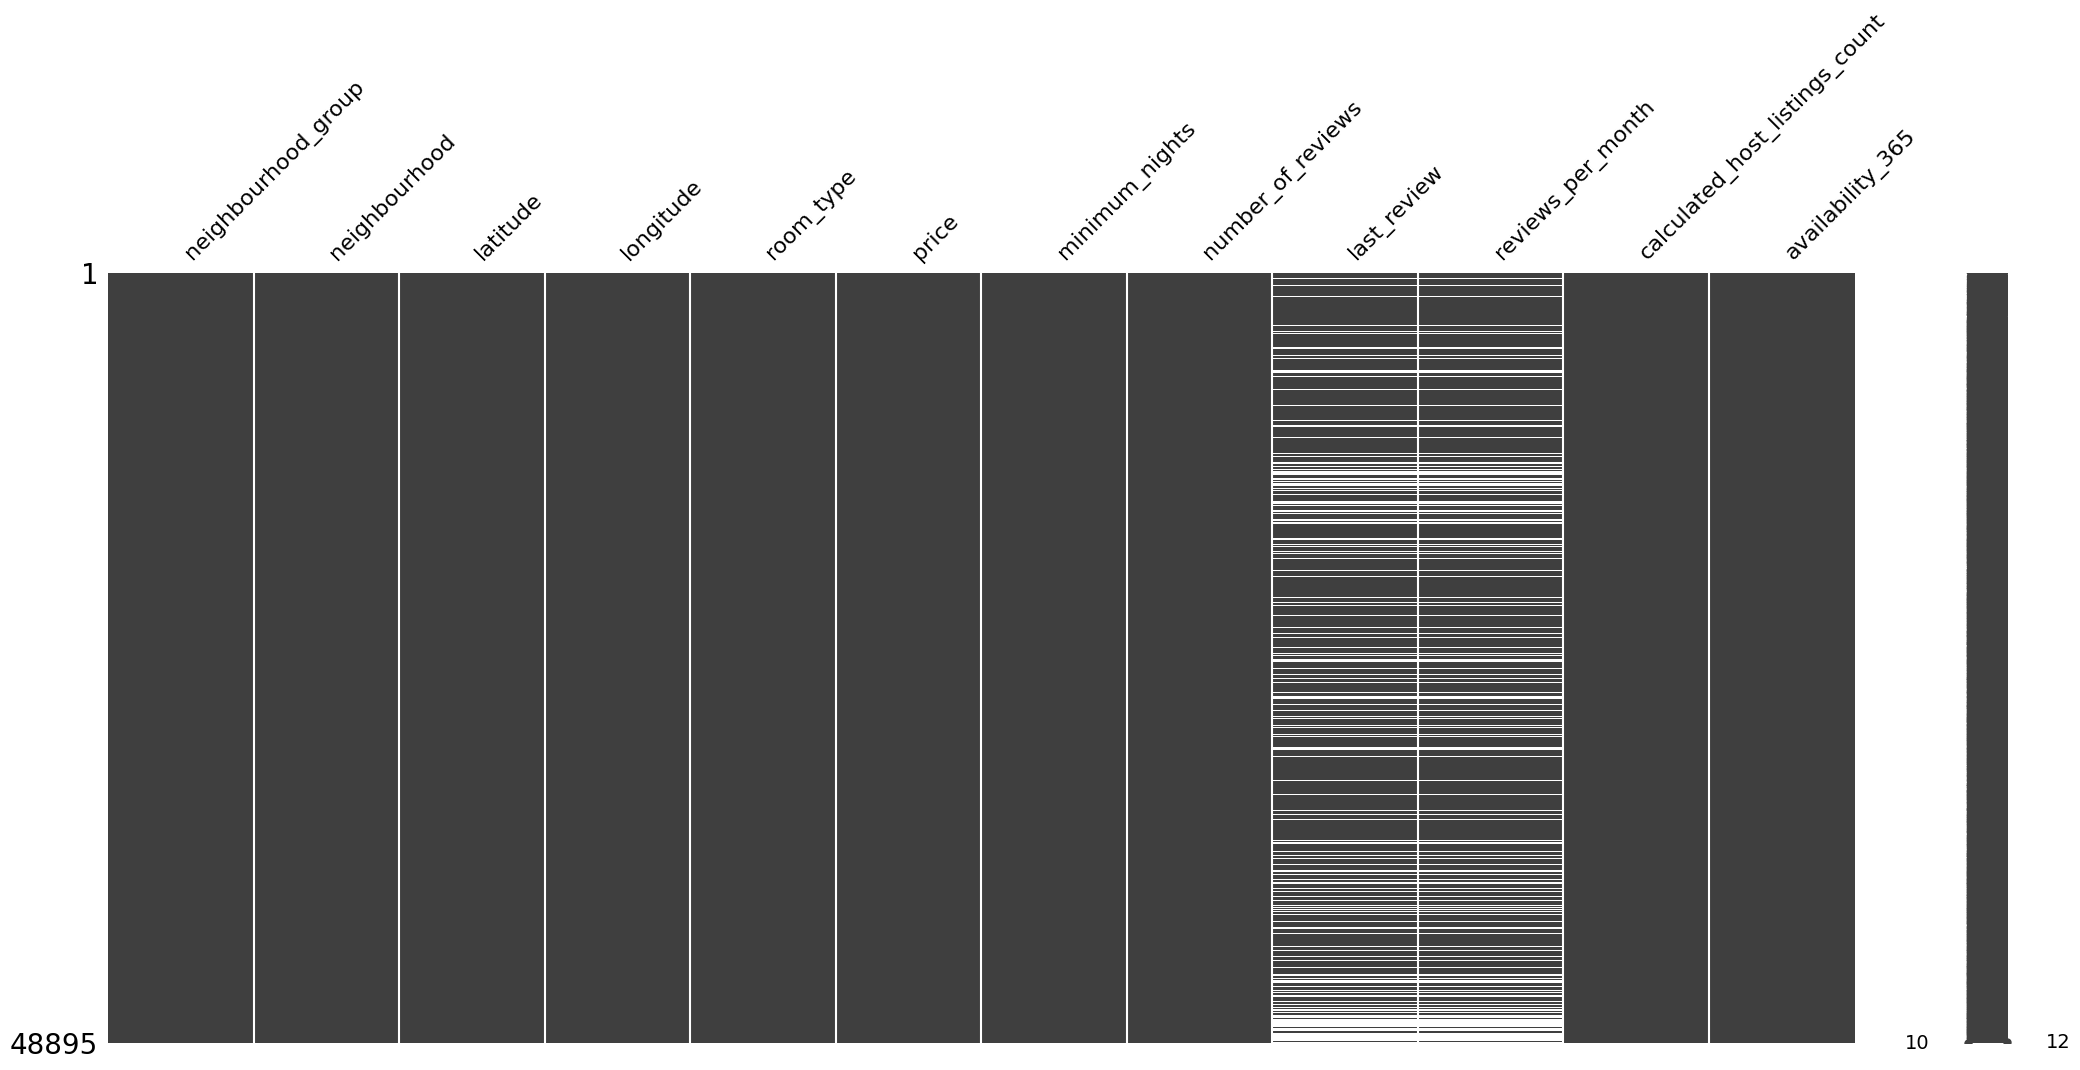

In [ ]:
msno.matrix(df)

Como podemos observar en la matriz de correlación, las columnas “last_review” y “reviews_per_month” están fuertemente relacionadas. Esto ocurre porque last_review solo tiene un valor cuando el alojamiento ha recibido alguna reseña, y por lo tanto depende directamente de reviews_per_month.
Para evitar que esta dependencia afecte la importancia de las variables a la hora de entrenar el modelo, vamos a reemplazar los valores nulos de reviews_per_month por 0, ya que representa correctamente que el anuncio no tiene reseñas mensuales sin distorsionar los datos

In [10]:
# Convertir valores NaN de la columna "reviews_per_month" = 0
df['reviews_per_month'].fillna(0,inplace=True)

/tmp/ipykernel_694/1802235567.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0,inplace=True)


<Axes: >

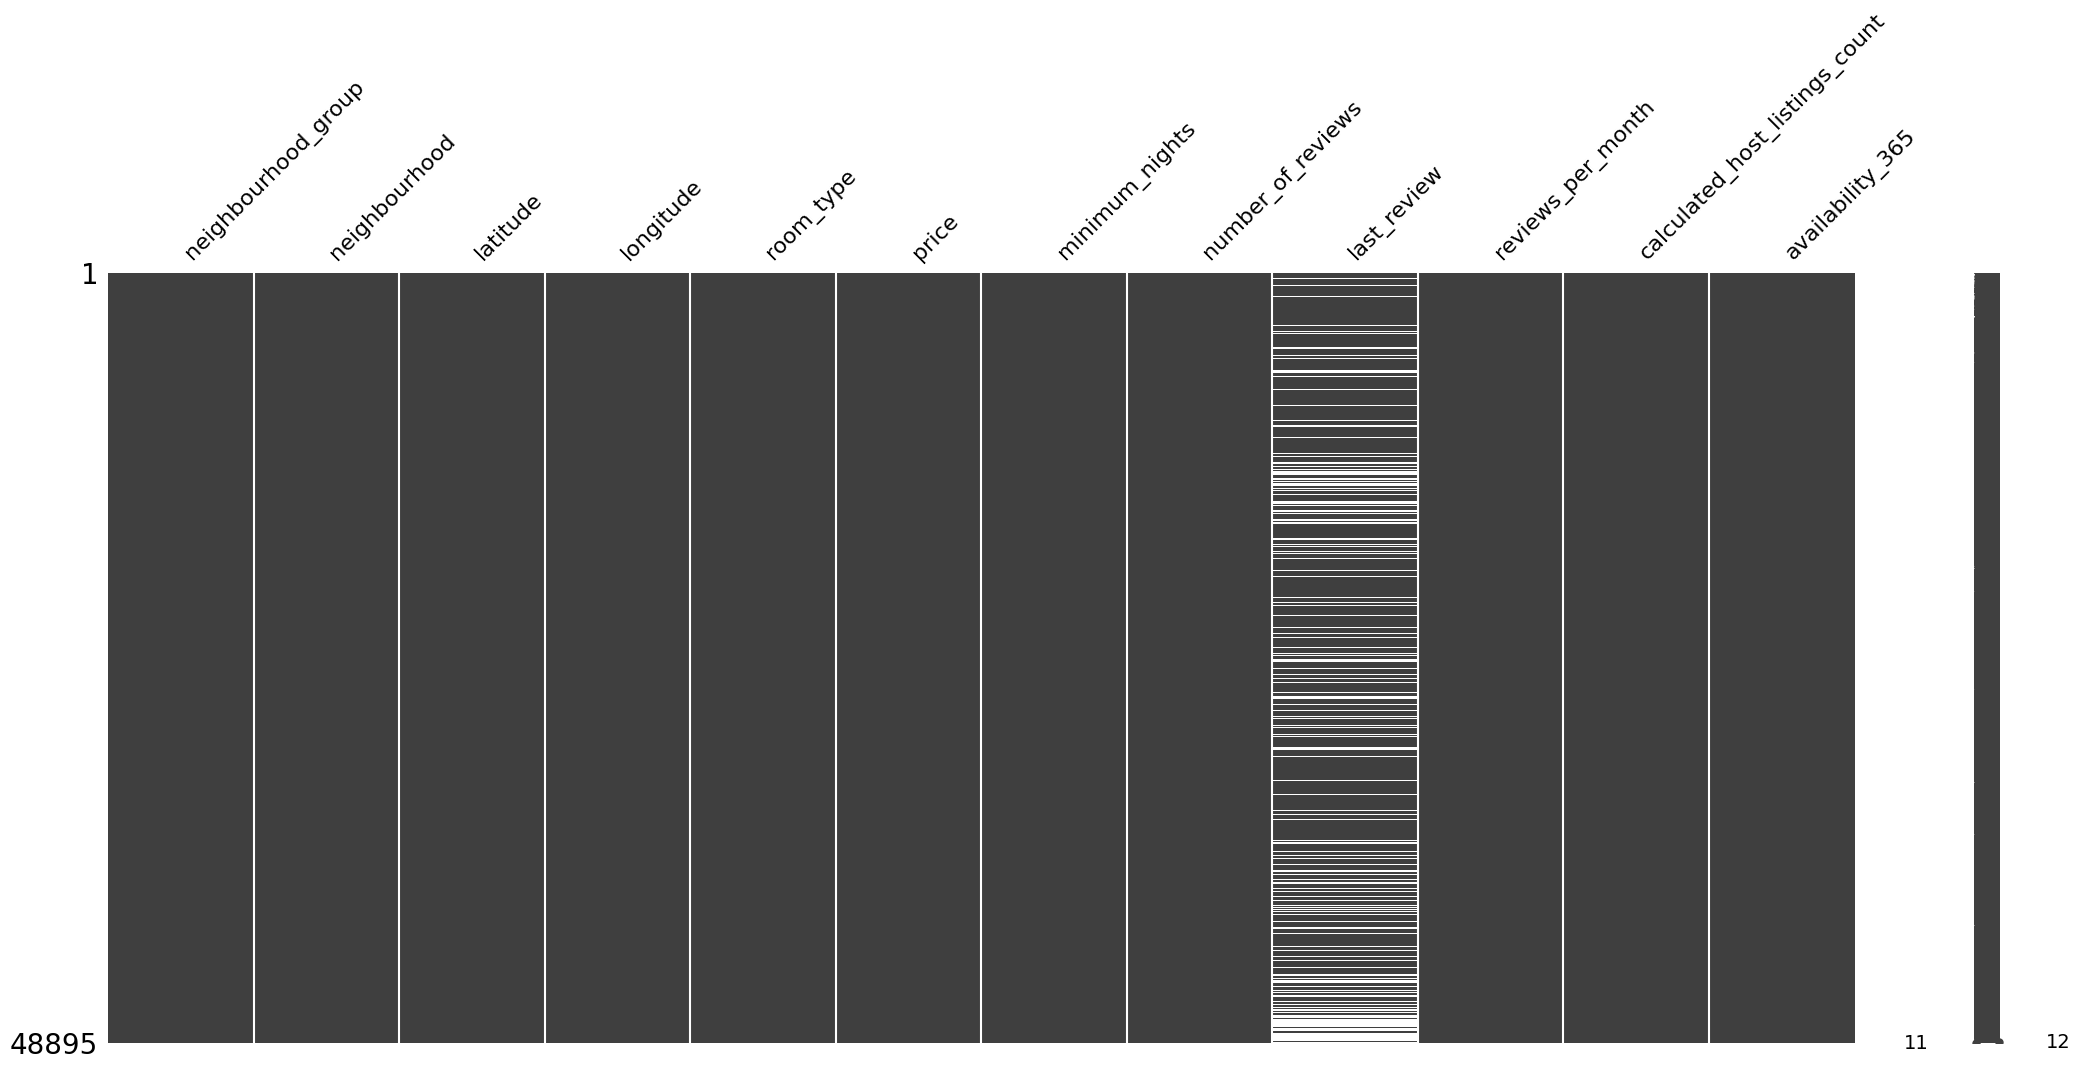

In [11]:
msno.matrix(df)

In [12]:
df.availability_365.describe()


count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64

##  3.0 Extracción de caracteristicas

Usando la columna “last_review”, vamos a crear una nueva columna numérica que indique cuántos días han pasado desde la última reseña registrada, esperando asi que nos pueda ser util en la selección de caracteristicas.

In [13]:
# crear columna "days_last_review"
df['last_review']= pd.to_datetime(df['last_review']) # last_review a datatime
cutoff_date = df['last_review'].max() # fecha mas reciente 
df['days_last_review'] = (cutoff_date - df['last_review']).dt.days


## 4.0 Train test split 

Hacemos el split del Train y Test 

In [14]:
X = df.drop('price',axis=1)
y = df['price']


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5.0 Codificación variables categóricas


Podemos observar en el siguiente codigo las variables categoricas que debemos codificiar antes de seguir con el algoritmo

In [16]:
# lista de variables categoricas del df 
variables = df.select_dtypes(include=['object', 'category']).columns.tolist()
variables

['neighbourhood_group', 'neighbourhood', 'room_type']

#### 5.1 Ordinal encoder: para variable Room type

In [17]:
room_type_order = [['Shared room','Private room','Entire home/apt']]

ordinal_encoder = OrdinalEncoder(categories=room_type_order,handle_unknown='use_encoded_value',unknown_value=-1)

X_train['room_type_encoded'] = ordinal_encoder.fit_transform(X_train[['room_type']])
X_test['room_type_encoded']= ordinal_encoder.transform(X_test[['room_type']])

X_train.drop('room_type',axis=1,inplace=True)
X_test.drop('room_type',axis=1,inplace=True)

X_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_last_review,room_type_encoded
32645,Brooklyn,Williamsburg,40.71577,-73.95530,3,11,2019-05-16,0.87,1,1,53.0,2.0
23615,Manhattan,Washington Heights,40.84917,-73.94048,2,2,2018-06-25,0.16,1,0,378.0,1.0
31183,Brooklyn,Bedford-Stuyvesant,40.68993,-73.95947,2,0,NaT,0.00,2,0,NaN,1.0
29260,Brooklyn,Bedford-Stuyvesant,40.68427,-73.93118,3,87,2019-07-05,4.91,1,267,3.0,2.0
7275,Queens,Woodside,40.74705,-73.89564,5,13,2018-12-18,0.25,1,0,202.0,1.0


#### 5.2 TargetEncoder : para variables "neighbourhood_group" , "neighbourhood"

In [18]:
cols = ["neighbourhood_group","neighbourhood"]
for column in cols:
    target_encoder = TargetEncoder(target_type ='continuous',smooth='auto',cv=5)
    
    X_train_col_enc = target_encoder.fit_transform(X_train[[column]],y_train)
    X_test_col_enc = target_encoder.transform(X_test[[column]])
    X_train[f'{column}_encoded'] = X_train_col_enc
    X_test[f'{column}_encoded'] = X_test_col_enc
    #Drop las columnas antiguas 
    X_train.drop(columns= column, axis=1, inplace=True)
    X_test.drop(columns= column, axis=1, inplace=True)



In [19]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 39116 entries, 32645 to 15795
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   latitude                        39116 non-null  float64       
 1   longitude                       39116 non-null  float64       
 2   minimum_nights                  39116 non-null  int64         
 3   number_of_reviews               39116 non-null  int64         
 4   last_review                     31010 non-null  datetime64[ns]
 5   reviews_per_month               39116 non-null  float64       
 6   calculated_host_listings_count  39116 non-null  int64         
 7   availability_365                39116 non-null  int64         
 8   days_last_review                31010 non-null  float64       
 9   room_type_encoded               39116 non-null  float64       
 10  neighbourhood_group_encoded     39116 non-null  float64       
 11  nei

>Nos aseguramos de que todas las columnas están codificadas 

In [20]:
X_train.drop(columns= 'last_review', axis=1, inplace=True)
X_test.drop(columns= 'last_review', axis=1, inplace=True)


## 6.0 Selección de características

Realizamos 3 metodos para luego compararlos

#### 6.1 Método 1: Feature importance de RF

In [21]:
# Entrenamiento de RF
model = RandomForestRegressor(random_state=42,n_jobs=-1).fit(X_train, y_train)

In [22]:

#Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

# Convertir a DataFrame
df_rf = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

# Calculamos la importancia acumulada
df_rf['rf_importance_acum'] = df_rf['rf_importance'].cumsum()

In [23]:
df_rf



,feature,rf_importance,rf_importance_acum
1,longitude,17.577998,17.577998
0,latitude,15.547008,33.125006
10,neighbourhood_encoded,13.338780,46.463787
7,days_last_review,12.842958,59.306745
6,availability_365,8.511282,67.818027
2,minimum_nights,7.911414,75.729441
8,room_type_encoded,6.170506,81.899947
5,calculated_host_listings_count,5.709700,87.609647
9,neighbourhood_group_encoded,5.050481,92.660128
4,reviews_per_month,4.167716,96.827845


#### 6.2 Método 2: Permutation/Shuffle importance

In [24]:
#Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train1, y_train1)

In [25]:
# Realizamos 10 permutaciones por cada característica
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')

In [26]:
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
1,longitude,69.690745
10,neighbourhood_encoded,44.571890
8,room_type_encoded,35.074010
4,reviews_per_month,23.486528
0,latitude,21.891775
7,days_last_review,18.095524
3,number_of_reviews,14.958994
9,neighbourhood_group_encoded,14.331473
2,minimum_nights,14.259741
5,calculated_host_listings_count,12.976212


#### 6.3 Método 3: SHAP

In [27]:

# Ajustamos el modelo
model_lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1).fit(X_train1, y_train1)

explainer = shap.Explainer(model_lgbm, X_val)   # usa el mismo X_val
shap_vals = explainer(X_val).values

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 31292, number of used features: 11
[LightGBM] [Info] Start training from score 153.698581


 98%|===================| 7645/7824 [00:18<00:00]        

In [28]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
8,room_type_encoded,27.852595
6,availability_365,14.138206
10,neighbourhood_encoded,13.068255
7,days_last_review,11.809176
1,longitude,7.434306
2,minimum_nights,7.246233
0,latitude,4.929808
4,reviews_per_month,4.767570
3,number_of_reviews,4.038647
5,calculated_host_listings_count,3.343447


## 7.0 SHAP Summary Bar Plot

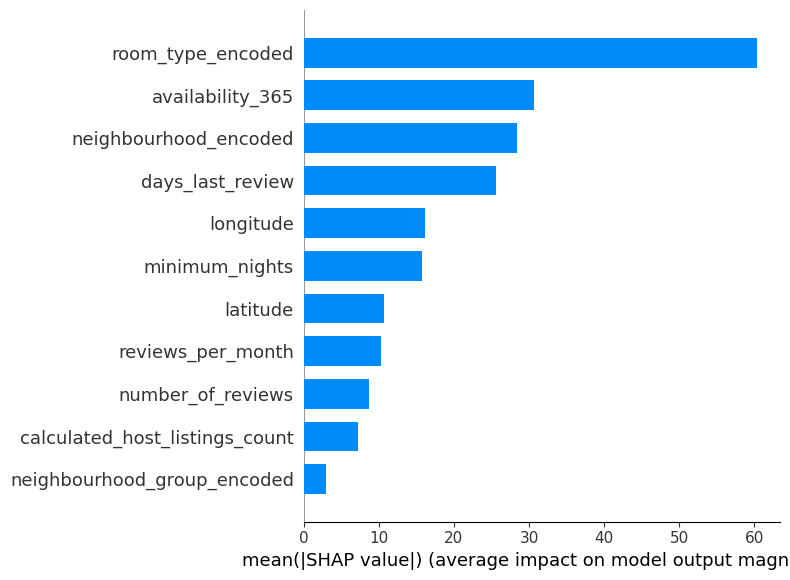

In [29]:
# --- SHAP Summary Bar Plot ---
shap.summary_plot(shap_vals, X_val, plot_type="bar")

In [30]:
df_importances = (
    df_rf
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
4,longitude,17.577998,17.577998,69.690745,7.434306
3,latitude,15.547008,33.125006,21.891775,4.929808
6,neighbourhood_encoded,13.338780,46.463787,44.571890,13.068255
2,days_last_review,12.842958,59.306745,18.095524,11.809176
0,availability_365,8.511282,67.818027,10.452372,14.138206
5,minimum_nights,7.911414,75.729441,14.259741,7.246233
10,room_type_encoded,6.170506,81.899947,35.074010,27.852595
1,calculated_host_listings_count,5.709700,87.609647,12.976212,3.343447
7,neighbourhood_group_encoded,5.050481,92.660128,14.331473,1.371757
9,reviews_per_month,4.167716,96.827845,23.486528,4.767570


In [31]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['shap_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_acum,perm_imp,shap_imp
4,longitude,17.577998,17.577998,69.690745,7.434306
3,latitude,15.547008,33.125006,21.891775,4.929808
6,neighbourhood_encoded,13.338780,46.463787,44.571890,13.068255
2,days_last_review,12.842958,59.306745,18.095524,11.809176
0,availability_365,8.511282,67.818027,10.452372,14.138206
5,minimum_nights,7.911414,75.729441,14.259741,7.246233
10,room_type_encoded,6.170506,81.899947,35.074010,27.852595
1,calculated_host_listings_count,5.709700,87.609647,12.976212,3.343447
7,neighbourhood_group_encoded,5.050481,92.660128,14.331473,1.371757
9,reviews_per_month,4.167716,96.827845,23.486528,4.767570
